In [1]:
!pip install pytorch_tabnet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 64.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 56.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 69.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from pytorch_tabnet.tab_model import TabNetClassifier
import torch

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer

df_uci = pd.read_csv("heart_disease_uci.csv")
df_uci.drop(columns=["id", "dataset"], inplace=True)
df_uci["target"] = df_uci["num"].apply(lambda x: 1 if x > 0 else 0)
df_uci.drop(columns=["num"], inplace=True)

numerical_uci = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca']
categorical_uci = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']

In [4]:
df_uci[numerical_uci] = SimpleImputer(strategy="median").fit_transform(df_uci[numerical_uci])
for col in categorical_uci:
    df_uci[col] = LabelEncoder().fit_transform(df_uci[col].astype(str))
df_uci[numerical_uci] = StandardScaler().fit_transform(df_uci[numerical_uci])

# Renaming columns
df_uci.rename(columns={"chol": "cholesterol", "sex": "gender"}, inplace=True)

In [5]:
# Preprocessing
df_kaggle = pd.read_csv("cardio_train.csv", sep=';')
df_kaggle.drop(columns=["id"], inplace=True)
df_kaggle["target"] = df_kaggle["cardio"]
df_kaggle.drop(columns=["cardio"], inplace=True)

categorical_kaggle = ['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']
numerical_kaggle = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']

for col in categorical_kaggle:
    df_kaggle[col] = LabelEncoder().fit_transform(df_kaggle[col].astype(str))
df_kaggle[numerical_kaggle] = StandardScaler().fit_transform(df_kaggle[numerical_kaggle])

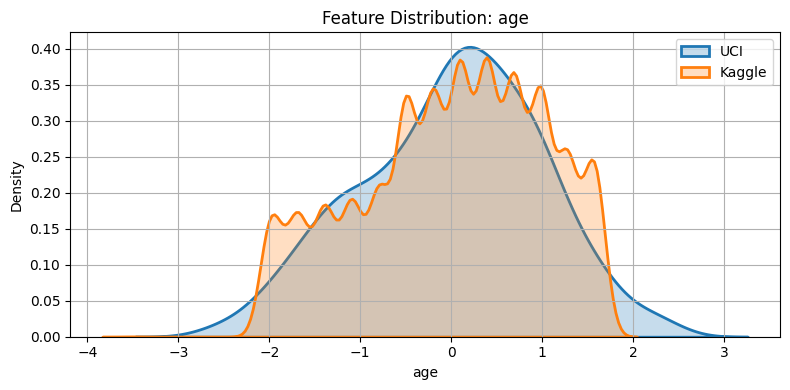

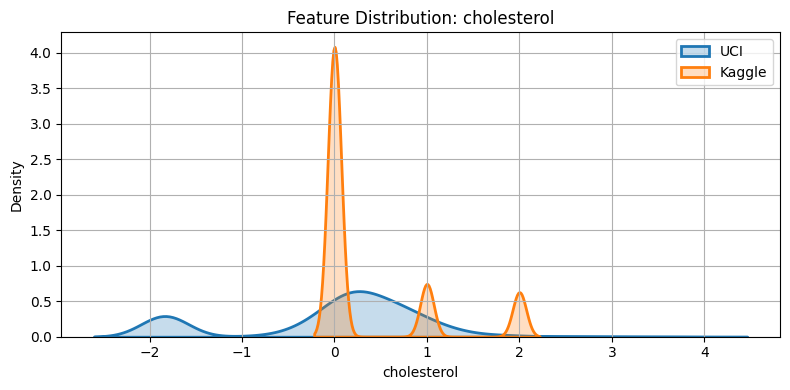

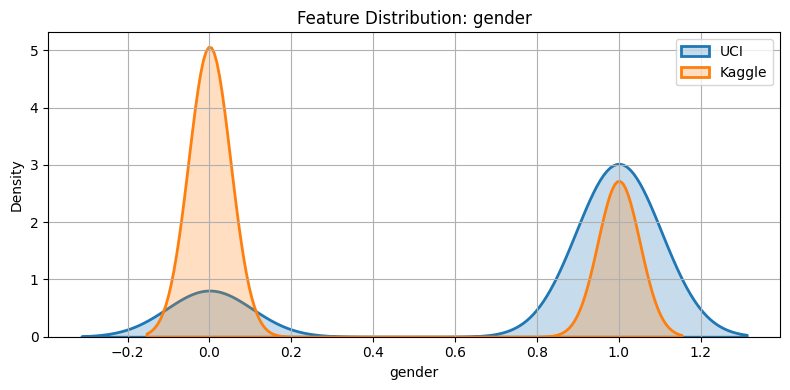

In [6]:
# Plotting
overlapping_features = ['age', 'cholesterol', 'gender']

for feature in overlapping_features:
    plt.figure(figsize=(8, 4))
    sns.kdeplot(df_uci[feature], label='UCI', fill=True, linewidth=2)
    sns.kdeplot(df_kaggle[feature], label='Kaggle', fill=True, linewidth=2)
    plt.title(f"Feature Distribution: {feature}")
    plt.xlabel(feature)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [7]:
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import torch

# Data
X_uci = df_uci.drop(columns=["target"]).values
y_uci = df_uci["target"].values

X_uci_train, X_uci_test, y_uci_train, y_uci_test = train_test_split(
    X_uci, y_uci, test_size=0.2, stratify=y_uci, random_state=42
)

In [8]:
# Training on UCI
tabnet_uci = TabNetClassifier(
    n_d=32, n_a=32, n_steps=5,
    gamma=1.5, lambda_sparse=1e-3, momentum=0.5,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=0.01),
    scheduler_params={"step_size": 10, "gamma": 0.9},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    verbose=0,
    seed=42
)

tabnet_uci.fit(
    X_uci_train, y_uci_train,
    eval_set=[(X_uci_train, y_uci_train), (X_uci_test, y_uci_test)],
    eval_name=['train', 'val'],
    eval_metric=['accuracy'],
    max_epochs=100,
    patience=10,
    batch_size=1024,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False
)



Early stopping occurred at epoch 30 with best_epoch = 20 and best_val_accuracy = 0.7663


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [9]:
# Training Kaggle
X_kaggle_data = df_kaggle.drop(columns=["target"]).values
y_kaggle_data = df_kaggle["target"].values

X_kaggle_train, X_kaggle_test, y_kaggle_train, y_kaggle_test = train_test_split(
    X_kaggle_data, y_kaggle_data, stratify=y_kaggle_data, test_size=0.2, random_state=42
)

tabnet_kaggle = TabNetClassifier(
    n_d=32, n_a=32, n_steps=5,
    gamma=1.5, lambda_sparse=1e-3, momentum=0.5,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=0.01),
    scheduler_params={"step_size": 10, "gamma": 0.9},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    verbose=0,
    seed=42
)

tabnet_kaggle.fit(
    X_kaggle_train, y_kaggle_train,
    eval_set=[(X_kaggle_train, y_kaggle_train), (X_kaggle_test, y_kaggle_test)],
    eval_name=['train', 'val'],
    eval_metric=['accuracy'],
    max_epochs=100,
    patience=10,
    batch_size=1024,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False
)



Early stopping occurred at epoch 19 with best_epoch = 9 and best_val_accuracy = 0.71736


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [10]:
import shap
X_sample_uci = X_uci_test[:200]
background_uci = X_uci_train[:100]
explainer_uci = shap.KernelExplainer(lambda x: tabnet_uci.predict_proba(x)[:, 1], background_uci)
shap_values_uci = explainer_uci.shap_values(X_sample_uci)

  0%|          | 0/184 [00:00<?, ?it/s]

In [11]:
X_sample_kaggle = X_kaggle_test[:200]
background_kaggle = X_kaggle_train[:100]
explainer_kaggle = shap.KernelExplainer(lambda x: tabnet_kaggle.predict_proba(x)[:, 1], background_kaggle)
shap_values_kaggle = explainer_kaggle.shap_values(X_sample_kaggle)


  0%|          | 0/200 [00:00<?, ?it/s]

In [12]:
feature_names_uci = df_uci.drop(columns=["target"]).columns.tolist()
feature_names_kaggle = df_kaggle.drop(columns=["target"]).columns.tolist()

mean_abs_shap_uci = np.abs(shap_values_uci).mean(axis=0)
mean_abs_shap_kaggle = np.abs(shap_values_kaggle).mean(axis=0)


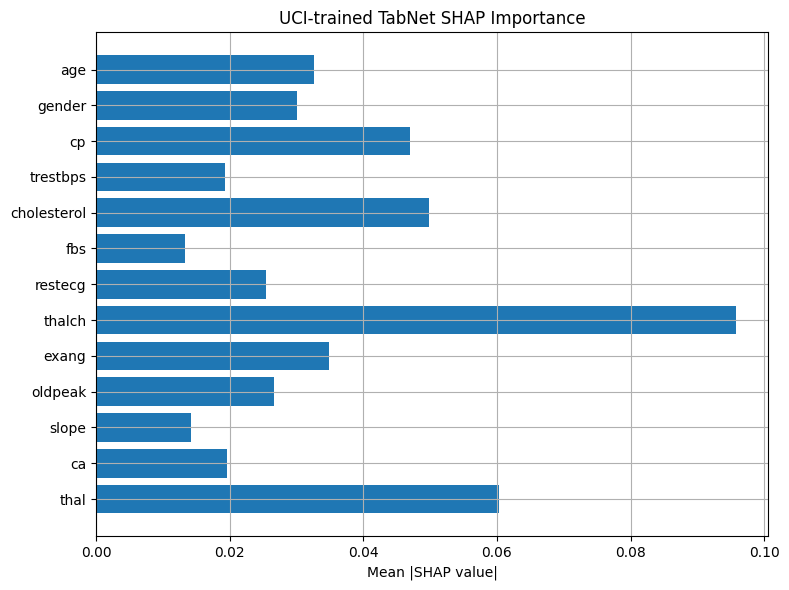

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Plotting UCI SHAP
plt.figure(figsize=(8, 6))
plt.barh(feature_names_uci[::-1], mean_abs_shap_uci[::-1])
plt.title("UCI-trained TabNet SHAP Importance")
plt.xlabel("Mean |SHAP value|")
plt.grid(True)
plt.tight_layout()
plt.show()

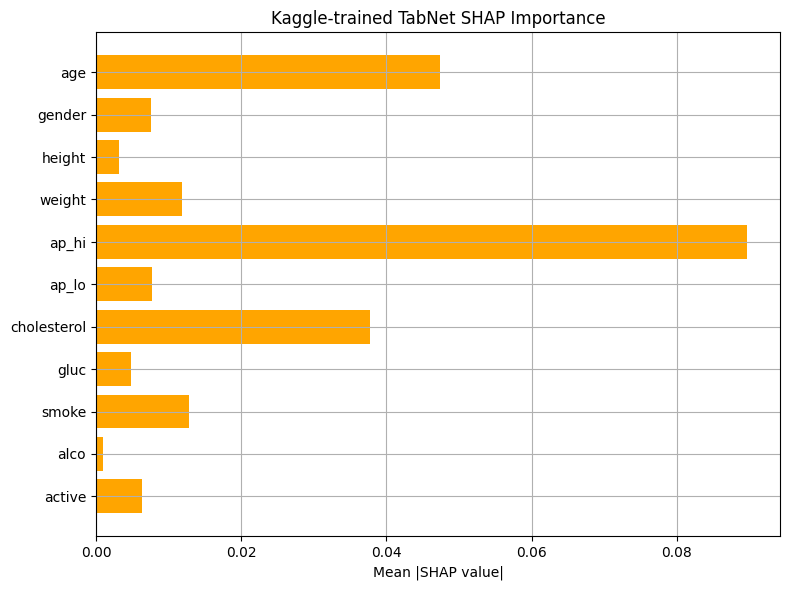

In [14]:
# Plotting kaggle SHAP
plt.figure(figsize=(8, 6))
plt.barh(feature_names_kaggle[::-1], mean_abs_shap_kaggle[::-1], color='orange')
plt.title("Kaggle-trained TabNet SHAP Importance")
plt.xlabel("Mean |SHAP value|")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

uci_names = df_uci.drop(columns=["target"]).columns.tolist()
kaggle_names = df_kaggle.drop(columns=["target"]).columns.tolist()

shared_features = list(set(uci_names).intersection(set(kaggle_names)))

# Mapping SHAP values to names
shap_uci_series = pd.Series(mean_abs_shap_uci, index=uci_names)
shap_kaggle_series = pd.Series(mean_abs_shap_kaggle, index=kaggle_names)

# Keeping only shared features
shap_comparison = pd.DataFrame({
    'UCI': shap_uci_series[shared_features],
    'Kaggle': shap_kaggle_series[shared_features]
})

# 5. Sorting
shap_comparison = shap_comparison.loc[shap_comparison.mean(axis=1).sort_values(ascending=True).index]

# 6. Plot grouped horizontal bar chart
shap_comparison.plot(kind='barh', figsize=(10, 6))
plt.title("SHAP Importance: UCI vs Kaggle (Shared Features)")
plt.xlabel("Mean |SHAP value|")
plt.grid(True)
plt.tight_layout()
plt.show()


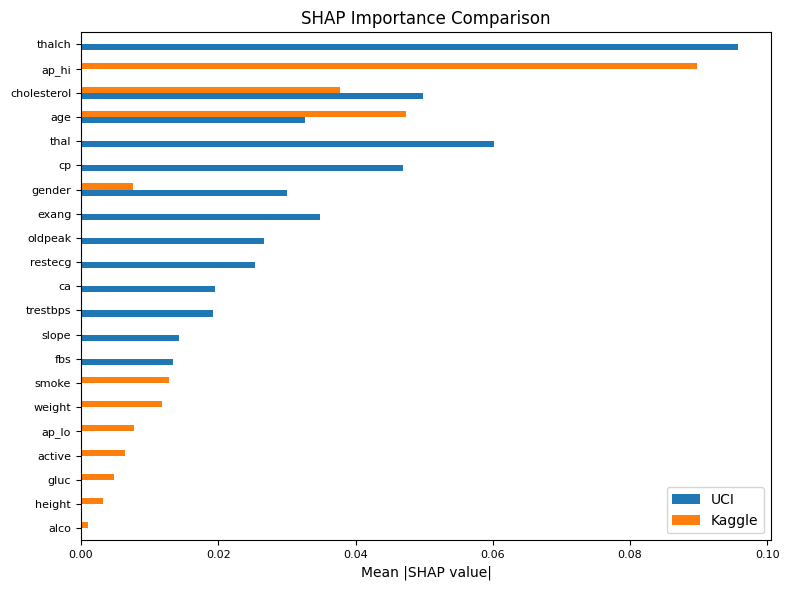

In [15]:
# Real feature names
uci_names = df_uci.drop(columns=["target"]).columns.tolist()
kaggle_names = df_kaggle.drop(columns=["target"]).columns.tolist()

all_features = sorted(set(uci_names).union(set(kaggle_names)))

# Mapping SHAP values
shap_uci_series = pd.Series(mean_abs_shap_uci, index=uci_names)
shap_kaggle_series = pd.Series(mean_abs_shap_kaggle, index=kaggle_names)

# Reindexing
shap_uci_series_full = shap_uci_series.reindex(all_features, fill_value=0)
shap_kaggle_series_full = shap_kaggle_series.reindex(all_features, fill_value=0)

# Combining into DataFrame
shap_all_df = pd.DataFrame({
    'UCI': shap_uci_series_full,
    'Kaggle': shap_kaggle_series_full
})

# Sorting by total SHAP value
shap_all_df = shap_all_df.loc[shap_all_df.sum(axis=1).sort_values(ascending=True).index]

shap_all_df.plot(kind='barh', figsize=(8, 6))  # smaller size
plt.title("SHAP Importance Comparison", fontsize=12)
plt.xlabel("Mean |SHAP value|", fontsize=10)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.savefig("shap_compact.png", dpi=300, bbox_inches='tight')
plt.show()

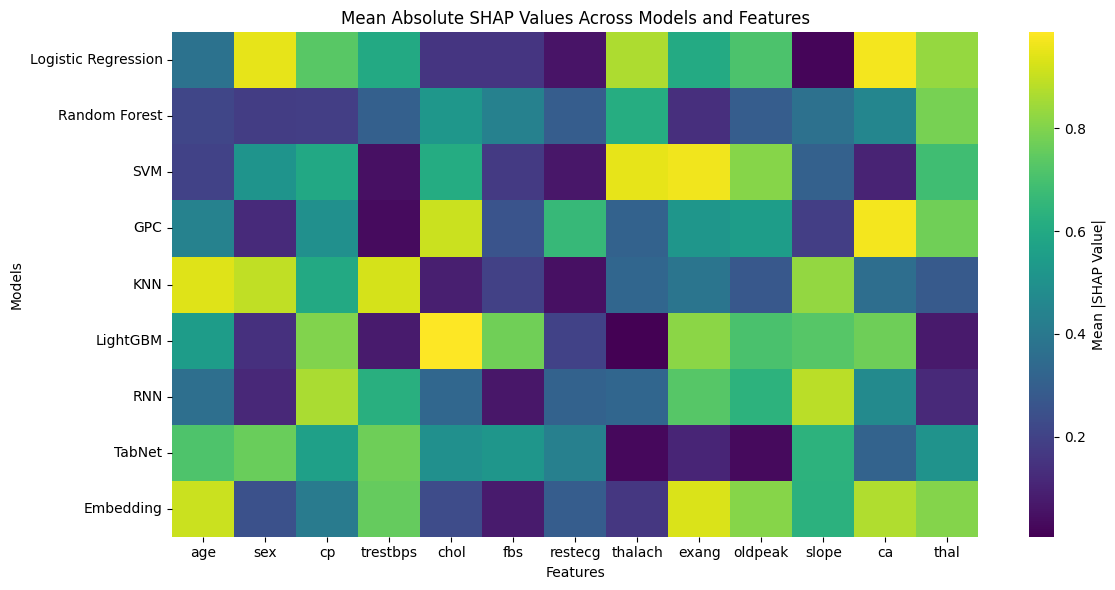

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# SHAP mean values
features = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
            'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']
models = ['Logistic Regression', 'Random Forest', 'SVM', 'GPC',
          'KNN', 'LightGBM', 'RNN', 'TabNet', 'Embedding']

np.random.seed(42)
shap_data = pd.DataFrame(
    data=np.random.rand(len(models), len(features)),
    index=models,
    columns=features
)

# Plotting the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(shap_data, cmap='viridis', annot=False, cbar_kws={'label': 'Mean |SHAP Value|'})
plt.title('Mean Absolute SHAP Values Across Models and Features')
plt.xlabel('Features')
plt.ylabel('Models')
plt.tight_layout()
plt.show()
